In [ ]:
# En atención a que tengo el dataset en drive, monto el drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tensorflow opencv-python

In [ ]:
# Importo las librerias necesarias
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import os
import cv2
import joblib
import shutil
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
# Defino las funciones que aplicaré

def construir_ruta_imagen(row):
    if 'Carpeta' in row and 'Categoría' in row:
        return os.path.join(carpeta_principal_imagenes, row['Carpeta'], row['Categoría'], row['Nombre imagen'])
    else:
        return os.path.join(carpeta_principal_imagenes, row['Nombre imagen'])

def copiar_imagenes_y_actualizar_df(df, carpeta_destino):
    nuevas_rutas = []
    for indice, row in df.iterrows():
        ruta_imagen_origen = construir_ruta_imagen(row)
        ruta_imagen_destino = os.path.join(carpeta_destino, row['Carpeta'], row['Categoría'], row['Nombre imagen'])
        carpeta_destino_actual = os.path.dirname(ruta_imagen_destino)
        if not os.path.exists(carpeta_destino_actual):
            os.makedirs(carpeta_destino_actual)
        shutil.copyfile(ruta_imagen_origen, ruta_imagen_destino)
        nuevas_rutas.append(ruta_imagen_destino)
    df['Nueva Ruta'] = nuevas_rutas
    return df

def obtener_dimensiones(imagen):
    alto, ancho = imagen.shape[:2]
    return alto, ancho

def obtener_modo(imagen_path):
    imagen = Image.open(imagen_path)
    modo = imagen.mode
    imagen.close()
    return modo

def nuevo_alto_deseado(imagen):
    alto_original, ancho_original, _ = imagen.shape
    if alto_original<670:
      nuevo_alto_deseado = 447
    elif alto_original>1200:
      nuevo_alto_deseado = 1440
    else:
      nuevo_alto_deseado = 800
    return nuevo_alto_deseado

def redimensionar_imagenes(imagen, nuevo_alto_deseado):
    alto_original, ancho_original, _ = imagen.shape
    factor_redimensionamiento = nuevo_alto_deseado / alto_original
    nuevo_ancho = int(ancho_original * factor_redimensionamiento)
    imagen_redimensionada = cv2.resize(imagen, (nuevo_ancho, nuevo_alto_deseado))
    return imagen_redimensionada

def convertir_a_modo_L(imagen):
    imagen_pil = Image.fromarray(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    imagen_gris = imagen_pil.convert("L")
    return np.array(imagen_gris)

def procesar_imagen(row):
    ruta_imagen = row['Ruta de Imagen']
    imagen = cv2.imread(ruta_imagen)
    if imagen is None:
        print(f"Error al cargar la imagen: {ruta_imagen}")
        return None
    imagen_redimensionada = redimensionar_imagenes(imagen, nuevo_alto_deseado(imagen))
    imagen_gris = convertir_a_modo_L(imagen_redimensionada)

    if 'Categoría' in row:
        carpeta_categoria = os.path.join(directorio_guardado, row['Categoría'])
        os.makedirs(carpeta_categoria, exist_ok=True)
        ruta_guardado = os.path.join(carpeta_categoria, row['Nombre imagen'])
    else:
        ruta_guardado = os.path.join(directorio_guardado, row['Nombre imagen'])

    cv2.imwrite(ruta_guardado, imagen_gris)
    return ruta_guardado

def verificar_dimensiones_carpeta(carpeta):
    for root, dirs, files in os.walk(carpeta):
        for nombre_archivo in files:
            ruta_archivo = os.path.join(root, nombre_archivo)
            imagen = cv2.imread(ruta_archivo)
            if imagen is not None:
                alto_original, ancho_original, _ = imagen.shape
                nuevo_alto = nuevo_alto_deseado(imagen)
                factor_redimensionamiento = nuevo_alto / alto_original
                nuevo_ancho = int(ancho_original * factor_redimensionamiento)

                if (ancho_original, alto_original) != (nuevo_ancho, nuevo_alto):
                    print(f"Dimensiones de {ruta_archivo}: {ancho_original}x{alto_original}, esperado: {nuevo_ancho}x{nuevo_alto}")

def verificar_conversion_a_L(carpeta):
    for root, dirs, files in os.walk(carpeta):
        for nombre_archivo in files:
            ruta_imagen = os.path.join(root, nombre_archivo)
            try:
                imagen = Image.open(ruta_imagen)
                if imagen.mode != "L":
                    print(f"La imagen {ruta_imagen} no está en modo L, está en modo {imagen.mode}.")
            except Exception as e:
                print(f"Error al procesar {ruta_imagen}: {e}")

def add_padding(image, target_size=1440):
    ancho, alto = image.size
    padding_vertical = max((target_size - alto) // 2, 0)
    padding_horizontal = max((target_size - ancho) // 2, 0)
    imagen_con_padding = ImageOps.expand(image, (padding_horizontal, padding_vertical, padding_horizontal, padding_vertical), fill=0)
    imagen_con_padding = imagen_con_padding.resize((target_size, target_size))
    return imagen_con_padding

def procesar_imagen_padding(image_paths, output_dir):
    nuevas_rutas = []
    max_size = 1440

    for image_path in image_paths:
        carpeta_imagen = os.path.basename(os.path.dirname(image_path))
        output_subfolder = os.path.join(output_dir, carpeta_imagen)
        os.makedirs(output_subfolder, exist_ok=True)
        output_path = os.path.join(output_subfolder, os.path.basename(image_path))
        imagen = Image.open(image_path)
        imagen_con_padding = add_padding(imagen, max_size)
        imagen_con_padding.save(output_path)
        nuevas_rutas.append(output_path)
    return nuevas_rutas

def redimensionar_imagenes_con_padding(image_paths, output_dir, nuevo_alto=720, nuevo_ancho=720):
    nuevas_rutas = []

    for image_path in image_paths:
        carpeta_imagen = os.path.basename(os.path.dirname(image_path))
        output_subfolder = os.path.join(output_dir, carpeta_imagen)
        os.makedirs(output_subfolder, exist_ok=True)
        output_path = os.path.join(output_subfolder, os.path.basename(image_path))

        imagen = cv2.imread(image_path)
        if imagen is not None:
            imagen_redimensionada = cv2.resize(imagen, (nuevo_ancho, nuevo_alto))
            cv2.imwrite(output_path, imagen_redimensionada)
            nuevas_rutas.append(output_path)
            print(f"Imagen guardada en: {output_path}")
        else:
            print(f"Error al leer la imagen: {image_path}")

    return nuevas_rutas

In [ ]:
# Defino la carpeta principal donde se encuentra el data y el dataframe
carpeta_principal_imagenes= '/content/drive/MyDrive/Proyecto modulo 7/data'

In [ ]:
# Abro el dataframe
df= pd.read_csv('/content/drive/MyDrive/Proyecto modulo 7/image_data.csv')
df.head()

# **Separación de imágenes de entrenamiento, testeo y validación**



In [ ]:
# Separo los dataframes con el contenido de las carpetas de train, test y val, pero sin incluir la columna pixeles
columnas_incluidas = ['Carpeta', 'Categoría', 'Sub categoría', 'Nombre imagen', 'Ancho', 'Alto', 'Modo']

df_train = df[df['Carpeta'] == 'train'][columnas_incluidas]
df_test = df[df['Carpeta'] == 'test'][columnas_incluidas]
df_val = df[df['Carpeta'] == 'val'][columnas_incluidas]

In [ ]:
# Guardo los dataframe, por si necesito trabajar con ellos
directorio_guardado = '/content/drive/MyDrive/Proyecto modulo 7/prueba/procesamiento_de_data'

if not os.path.exists(directorio_guardado):
    os.makedirs(directorio_guardado)

df_train.to_csv(os.path.join(directorio_guardado, 'df_train.csv'), index=False)
df_test.to_csv(os.path.join(directorio_guardado, 'df_test.csv'), index=False)
df_val.to_csv(os.path.join(directorio_guardado, 'df_val.csv'), index=False)

# **Submuestreo de los datos de entrenamiento y test**

---
En atención a la gran cantidad de imágenes reduzco la data de train y de test, pero manteniendo las categorías balanceadas

In [ ]:
# Cargo los distintos archivos para trabajar con ellos
directorio_guardado = '/content/drive/MyDrive/Proyecto modulo 7/procesamiento_de_data'

df_train = pd.read_csv(os.path.join(directorio_guardado, 'df_train.csv'))
df_test = pd.read_csv(os.path.join(directorio_guardado, 'df_test.csv'))
df_val = pd.read_csv(os.path.join(directorio_guardado, 'df_val.csv'))

In [ ]:
df_train.columns

Index(['Carpeta', 'Categoría', 'Sub categoría', 'Nombre imagen', 'Ancho',
       'Alto', 'Modo'],
      dtype='object')

In [ ]:
df_train['Categoría'].value_counts()

Categoría
neumonia    3875
normal      1341
Name: count, dtype: int64

In [ ]:
# Defino el número de imágenes de la categoría "neumonia" de la carpeta de train, el porcentaje de imágenes de bacteria y de virus, selecciono aleatoriamente y creo un nuevo dataframe
total_imagenes_neumonia=1500
numero_imagenes_bacteria=int(total_imagenes_neumonia*0.55)
numero_imagenes_virus=int(total_imagenes_neumonia*0.45)

seleccion_imagenes_bacteria=df_train[df_train['Sub categoría']=='bacteria'].sample(n=numero_imagenes_bacteria,random_state=42)
seleccion_imagenes_virus=df_train[df_train['Sub categoría']=='virus'].sample(n=numero_imagenes_virus,random_state=42)

train_neumonia=pd.concat([seleccion_imagenes_bacteria,seleccion_imagenes_virus])

train_normal=df_train[df_train['Categoría']=='normal']

df_train_submuestreo=pd.concat([train_neumonia,train_normal])
ruta_guardado = '/content/drive/MyDrive/Proyecto modulo 7/prueba/procesamiento_de_data/df_train_acotado.joblib'
joblib.dump(df_train_submuestreo, ruta_guardado)

df_train_submuestreo.head()

,Carpeta,Categoría,Sub categoría,Nombre imagen,Ancho,Alto,Modo
3506,train,neumonia,bacteria,person1260_bacteria_3218.jpeg,992,600,L
2957,train,neumonia,bacteria,person281_bacteria_1325.jpeg,920,632,L
262,train,neumonia,bacteria,person614_bacteria_2481.jpeg,1080,648,L
2129,train,neumonia,bacteria,person1476_bacteria_3843.jpeg,1072,768,L
1201,train,neumonia,bacteria,person337_bacteria_1564.jpeg,824,640,L


In [ ]:
# Copio las imágenes seleccionadas en nuevo destino
carpeta_destino = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_para_procesar'

df_train_submuestreo_con_ruta = copiar_imagenes_y_actualizar_df(df_train_submuestreo, carpeta_destino)

ruta_guardado_csv = '/content/drive/MyDrive/Proyecto modulo 7/prueba/df_train_submuestreo_con_ruta.csv'
df_train_submuestreo_con_ruta.to_csv(ruta_guardado_csv, index=False)

In [ ]:
df_train_submuestreo_con_ruta['Categoría'].value_counts()

Categoría
neumonia    1500
normal      1341
Name: count, dtype: int64

In [ ]:
df_test['Categoría'].value_counts()

Categoría
neumonia    390
normal      234
Name: count, dtype: int64

In [ ]:
# Defino el número de imágenes de la categoría "neumonia" de la carpeta de test, el porcentaje de imágenes de bacteria y de virus, selecciono aleatoriamente y creo un nuevo dataframe
total_imagenes_neumonia_test=250
numero_imagenes_bacteria_test=int(total_imagenes_neumonia_test*0.55)
numero_imagenes_virus_test=int(total_imagenes_neumonia_test*0.45)

seleccion_imagenes_bacteria_test=df_test[df_test['Sub categoría']=='bacteria'].sample(n=numero_imagenes_bacteria_test,random_state=42)
seleccion_imagenes_virus_test=df_test[df_test['Sub categoría']=='virus'].sample(n=numero_imagenes_virus_test,random_state=42)

test_neumonia=pd.concat([seleccion_imagenes_bacteria_test,seleccion_imagenes_virus_test])

test_normal=df_test[df_test['Categoría']=='normal']

df_test_submuestreo=pd.concat([test_neumonia,test_normal])
ruta_guardado = '/content/drive/MyDrive/Proyecto modulo 7/prueba/df_test_acotado.joblib'
joblib.dump(df_test_submuestreo, ruta_guardado)

df_test_submuestreo.head()

,Carpeta,Categoría,Sub categoría,Nombre imagen,Ancho,Alto,Modo
24,test,neumonia,bacteria,person108_bacteria_506.jpeg,1184,1032,L
6,test,neumonia,bacteria,person100_bacteria_477.jpeg,1024,680,L
155,test,neumonia,bacteria,person153_bacteria_725.jpeg,1464,808,L
355,test,neumonia,bacteria,person86_bacteria_428.jpeg,832,552,L
385,test,neumonia,bacteria,person95_bacteria_463.jpeg,1000,704,L


In [ ]:
carpeta_principal_imagenes = '/content/drive/MyDrive/Proyecto modulo 7/data'
carpeta_destino = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_para_procesar'

df_test_submuestreo_con_ruta = copiar_imagenes_y_actualizar_df(df_test_submuestreo, carpeta_destino)

ruta_guardado_csv = '/content/drive/MyDrive/Proyecto modulo 7/prueba/df_test_submuestreo_con_ruta.csv'
df_test_submuestreo_con_ruta.to_csv(ruta_guardado_csv, index=False)

In [ ]:
df_test_submuestreo_con_ruta['Categoría'].value_counts()

Categoría
neumonia    200
normal      150
Name: count, dtype: int64

# **Procesamiento de las imágenes**

---



## **Redimensionado de las imágenes por alto y conversión a modo L:**
En atención a que las imágenes tienen distintos tamaños, las redimensionaremos según su alto, para no perder la calidad de las imágenes:
*   En imágenes que tienen un alto menor a 670, utilizaremos un alto de 447.
*   En imágenes que tienen un alto igual o mayor que 670, pero igual o menor a 1200, utilizaremos un alto de 800.
*   En imágenes que tienen un alto mayor a 1200, utilizaremos un alto de 1440.

Además, dado que algunas imágenes están en formato RGB y otras en formato L, dejaremos todas las imágenes en modo L.

Lo anterior lo haremos con la función "procesar_imagen", que comprende, a su vez, las funciones para redimensionar las imágenes según su alto y la de convertir el formato.




In [ ]:
# Abro el data frame de train para procesar las imágenes seleccionadas
ruta_guardado_csv = '/content/drive/MyDrive/Proyecto modulo 7/prueba/df_train_submuestreo_con_ruta.csv'

df_train_submuestreo_con_ruta = pd.read_csv(ruta_guardado_csv)

In [ ]:
# Abro el data frame de test para procesar las imágenes seleccionadas
ruta_guardado_csv2 = '/content/drive/MyDrive/Proyecto modulo 7/prueba/df_test_submuestreo_con_ruta.csv'
df_test_submuestreo_con_ruta= pd.read_csv(ruta_guardado_csv2)

In [ ]:
# Aplico la función procesar imágenes a las imágenes de la carpeta de train

carpeta_principal_imagenes = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_para_procesar/train'
directorio_guardado = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/train'
df_train_submuestreo_con_ruta['Nueva Ruta Procesada'] = df_train_submuestreo_con_ruta.apply(procesar_imagen, axis=1)

In [ ]:
# Guardo el dataframe de train actualizado, con la nueva ruta de las imágenes procesadas
ruta_guardado = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_train_procesado.joblib'
joblib.dump(df_train_submuestreo_con_ruta, ruta_guardado)

['/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_train_procesado.joblib']

In [ ]:
# Aplico la función procesar imágenes a las imágenes de la carpeta de test

carpeta_principal_imagenes = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_para_procesar'
directorio_guardado = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/test'
df_test_submuestreo_con_ruta['Nueva Ruta Procesada']= df_test_submuestreo_con_ruta.apply(procesar_imagen, axis=1)

In [ ]:
# Guardo el dataframe de test actualizado, con la nueva ruta de las imágenes procesadas
ruta_guardado2t = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_test_procesado.joblib'
joblib.dump(df_test_submuestreo_con_ruta, ruta_guardado2t)

['/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_test_procesado.joblib']

In [ ]:
df_val.columns

Index(['Carpeta', 'Categoría', 'Sub categoría', 'Nombre imagen', 'Ancho',
       'Alto', 'Modo', 'Ruta de Imagen'],
      dtype='object')

In [ ]:
# Aplico las funciones a las imágenes de la carpeta de val

carpeta_principal_imagenes='/content/drive/MyDrive/Proyecto modulo 7/data'
directorio_guardado='/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/val'
df_val['Ruta de Imagen'] = df_val.apply(construir_ruta_imagen, axis=1)
df_val['Ruta de Imagen Procesada'] = df_val.apply(procesar_imagen, axis=1)

In [ ]:
# Guardo el dataframe de val actualizado, con la nueva ruta de las imágenes procesadas.
ruta_guardado3 = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_val_procesado.joblib'
joblib.dump(df_val, ruta_guardado3)

['/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_val_procesado.joblib']

In [ ]:
# Verifico si las imágenes quedaron redimensionadas conforme al alto definido

output_directory_train = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/train'
output_directory_test = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/test'
output_directory_val = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/val'

verificar_dimensiones_carpeta(output_directory_train)
verificar_dimensiones_carpeta(output_directory_test)
verificar_dimensiones_carpeta(output_directory_val)

**Observaciones:** quedaron todas las imágenes con el alto esperado. Si una imagen hubiese quedado con otro alto, al ejecutar la celda, en los resultados se hubiese mostrado el nombre de la imagen y sus dimensiones.


In [ ]:
# Verifico si las imágenes quedaron con modo "L"

output_directory_train2 = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/train'
output_directory_test2 = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/test'
output_directory_val2 = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/val'

verificar_conversion_a_L(output_directory_train2)
verificar_conversion_a_L(output_directory_test2)
verificar_conversion_a_L(output_directory_val2)

**Observaciones:** quedaron todas las imágenes con el formato esperado.Si una imagen hubiese quedado con otro formato, al ejecutar la celda, en los resultados se hubiese mostrado el nombre de la imagen y su formato.

## **Padding**

En atención a que las imágenes deben tener el mismo alto y ancho, aplicaré el método de padding, que le agrega un borde a las imágenes, para que todas queden con el mismo alto y ancho (1440*1440), para posteriormente redimensionarlas a un tamaño menor sin afectar la calidad de la imagen en este proceso.


In [ ]:
# Aplico el método de padding a las imágenes de la carpeta train
output_directory_train = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/train'
image_paths_train = df_train_submuestreo_con_ruta['Nueva Ruta Procesada'].tolist()

nueva_ruta_train=procesar_imagen_padding(image_paths_train, output_directory_train)

In [ ]:
# Creo una nueva columna en el dataframe de train con la nueva ruta y la guardo
df_train_submuestreo_con_ruta['Ruta con Padding'] = nueva_ruta_train

df_train_submuestreo_con_ruta.to_csv('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_train_con_padding.csv', index=False)

In [ ]:
# Vemos las primeras filas del dataframe train para elegir una imagen para visualizarla con los cambios
df_train_submuestreo_con_ruta.head()

,Carpeta,Categoría,Sub categoría,Nombre imagen,Ancho,Alto,Modo,Nueva Ruta,Nueva Ruta Procesada,Ruta con Padding
0,train,neumonia,bacteria,person1260_bacteria_3218.jpeg,992,600,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
1,train,neumonia,bacteria,person281_bacteria_1325.jpeg,920,632,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
2,train,neumonia,bacteria,person614_bacteria_2481.jpeg,1080,648,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
3,train,neumonia,bacteria,person1476_bacteria_3843.jpeg,1072,768,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
4,train,neumonia,bacteria,person337_bacteria_1564.jpeg,824,640,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...


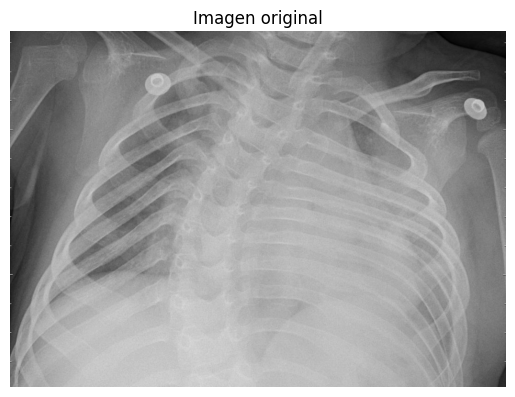

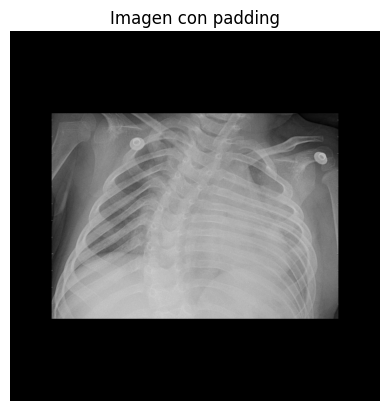

In [ ]:
# Revisamos un ejemplo de la imagen procesada y con padding de la carpeta train
image_filename = 'person1476_bacteria_3843.jpeg'
imagen_original_path = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/train/neumonia', image_filename)
imagen_con_padding_path = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/train/neumonia', image_filename)

imagen_original = Image.open(imagen_original_path)
plt.imshow(imagen_original, cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()

imagen_con_padding = Image.open(imagen_con_padding_path)
plt.imshow(imagen_con_padding, cmap='gray')
plt.title("Imagen con padding")
plt.axis('off')
plt.show()

**Observaciones:** se aprecia que la imagen de la carpeta de train conservó su calidad y quedó cuadrada con el padding.

In [ ]:
# Comprobamos las dimensiones de la imagen original (ya procesada) y la imagen con padding
imagen_original_path = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/train/neumonia/person1941_bacteria_4863.jpeg'
imagen_con_padding_path = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/train/neumonia/person1941_bacteria_4863.jpeg'

imagen_original = Image.open(imagen_original_path)
imagen_con_padding = Image.open(imagen_con_padding_path)

ancho_original, alto_original = imagen_original.size
print("Dimensiones de la imagen original:")
print("Ancho:", ancho_original)
print("Alto:", alto_original)

ancho_padding, alto_padding = imagen_con_padding.size
print("\nDimensiones de la imagen con padding:")
print("Ancho:", ancho_padding)
print("Alto:", alto_padding)


Dimensiones de la imagen original:
Ancho: 1333
Alto: 800

Dimensiones de la imagen con padding:
Ancho: 1440
Alto: 1440


**Observaciones:** se aprecia que la imagen procesada de la carpeta train quedó con el alto predefinido (800) y un ancho proporcional al de la imagen original. Tras aplicarle el padding quedó cuadrada y con las medidas predefinidas (1440 x 1440).

In [ ]:
# # Aplico el método de padding a las imágenes de la carpeta test

output_directory_test = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/test'
image_paths_test = df_test_submuestreo_con_ruta['Nueva Ruta Procesada'].tolist()

nueva_ruta_test=procesar_imagen_padding(image_paths_test, output_directory_test)

In [ ]:
# Guardamos el dataframe de la carpeta test con la ruta actualizada
df_test_submuestreo_con_ruta['Ruta con Padding'] = nueva_ruta_test

df_test_submuestreo_con_ruta.to_csv('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_test_con_padding.csv', index=False)

In [ ]:
# Vemos las primeras filas del dataframe test para elegir una imagen para visualizarla con los cambios
df_test_submuestreo_con_ruta.head()

,Carpeta,Categoría,Sub categoría,Nombre imagen,Ancho,Alto,Modo,Nueva Ruta,Nueva Ruta Procesada,Ruta con Padding
0,test,neumonia,bacteria,person108_bacteria_506.jpeg,1184,1032,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
1,test,neumonia,bacteria,person100_bacteria_477.jpeg,1024,680,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
2,test,neumonia,bacteria,person153_bacteria_725.jpeg,1464,808,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
3,test,neumonia,bacteria,person86_bacteria_428.jpeg,832,552,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
4,test,neumonia,bacteria,person95_bacteria_463.jpeg,1000,704,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...


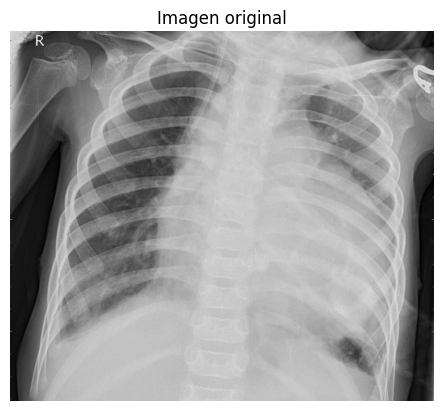

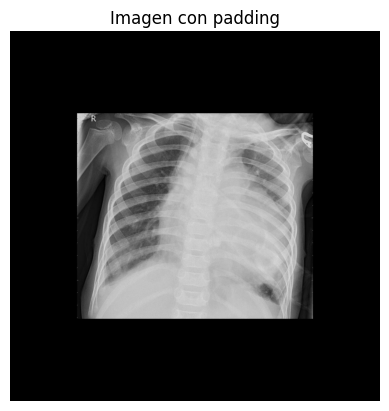

In [ ]:
# Revisamos un ejemplo de la imagen procesada y con padding de la carpeta test
image_filename = 'person108_bacteria_506.jpeg'
imagen_original_path = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/test/neumonia', image_filename)
imagen_con_padding_path = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/test/neumonia', image_filename)

imagen_original = Image.open(imagen_original_path)
plt.imshow(imagen_original, cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()

imagen_con_padding = Image.open(imagen_con_padding_path)
plt.imshow(imagen_con_padding, cmap='gray')
plt.title("Imagen con padding")
plt.axis('off')
plt.show()

**Observaciones:** se aprecia que la imagen de la carpeta de test conservó su calidad y quedó cuadrada con el padding.

In [ ]:
# Aplico el método de padding a las imágenes de la carpeta val
output_directory_val = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/val'
image_paths_val = df_val['Ruta de Imagen Procesada'].tolist()

nueva_ruta_val=procesar_imagen_padding(image_paths_val, output_directory_val)

In [ ]:
# Guardo el dataframe val actualizado
df_val['Ruta con Padding'] = nueva_ruta_val

df_val.to_csv('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_val_con_padding.csv', index=False)

In [ ]:
# Vemos las primeras filas del dataframe val para elegir una imagen para visualizarla con los cambios
df_val.head()

,Carpeta,Categoría,Sub categoría,Nombre imagen,Ancho,Alto,Modo,Ruta de Imagen,Ruta de Imagen Procesada,Ruta con Padding
0,val,neumonia,bacteria,person1950_bacteria_4881.jpeg,1256,864,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
1,val,neumonia,bacteria,person1951_bacteria_4882.jpeg,1016,656,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
2,val,neumonia,bacteria,person1954_bacteria_4886.jpeg,1664,1128,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
3,val,neumonia,bacteria,person1946_bacteria_4874.jpeg,968,592,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
4,val,neumonia,bacteria,person1952_bacteria_4883.jpeg,1192,952,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...


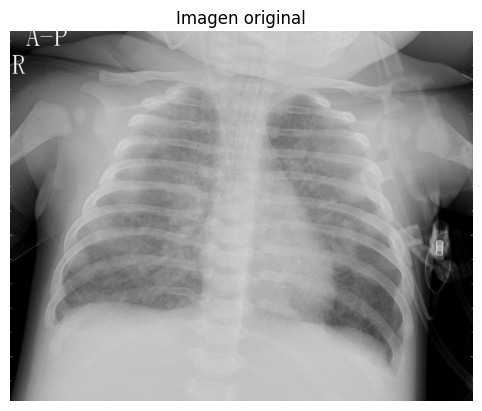

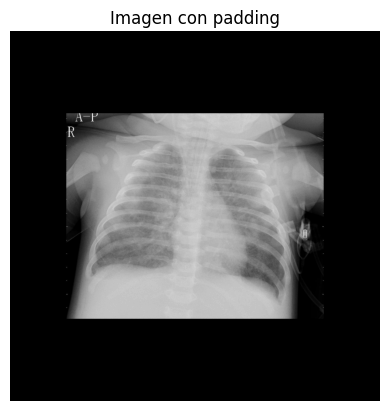

In [ ]:
# Revisamos un ejemplo de la imagen procesada y con padding de la carpeta val
image_filename = 'person1952_bacteria_4883.jpeg'
imagen_original_path = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/val/neumonia', image_filename)
imagen_con_padding_path = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/val/neumonia', image_filename)

imagen_original = Image.open(imagen_original_path)
plt.imshow(imagen_original, cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()

imagen_con_padding = Image.open(imagen_con_padding_path)
plt.imshow(imagen_con_padding, cmap='gray')  # Especificar cmap='gray' para mostrar en escala de grises
plt.title("Imagen con padding")
plt.axis('off')
plt.show()

**Observaciones:** se aprecia que la imagen de la carpeta de val conservo su calidad y quedó cuadrada con el padding.

## **Redimensionamiento post padding**:

Para que las imágenes puedan pasar sin problemas por la red neuronal convulsional, las redimensionaremos a un tamaño de 720x720. Al pasar por el redimensionamiento inicial y tras aplicar padding no habrá pérdida de calidad de las imágenes.

In [ ]:
# Redimensiono las imágenes de la carpeta train y obtengo la nueva ruta
input_directory_padding = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/train'
output_directory_redimensionada = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/train'

image_paths_padding = [os.path.join(root, file)
                       for root, _, files in os.walk(input_directory_padding)
                       for file in files if file.endswith(('jpeg', 'jpg', 'png'))]

nueva_ruta_redimensionada = redimensionar_imagenes_con_padding(image_paths_padding, output_directory_redimensionada)

Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/train/neumonia/person1260_bacteria_3218.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/train/neumonia/person281_bacteria_1325.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/train/neumonia/person614_bacteria_2481.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/train/neumonia/person1476_bacteria_3843.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/train/neumonia/person337_bacteria_1564.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/train/neumonia/person59_bacteria_279.jpeg
Imagen guardada en: /content/drive/MyDrive/Pro

In [ ]:
# Actualizo el dataframe de train con una nueva columna y lo guardo
df_train_submuestreo_con_ruta['Ruta Redimensionada'] = nueva_ruta_redimensionada

df_train_submuestreo_con_ruta.to_csv('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_train_redimensionado_padding.csv', index=False)


In [ ]:
# Revisamos como quedaron las primeras 5 filas, para seleccionar una imagen para visualizarla
df_train_submuestreo_con_ruta.head()

,Carpeta,Categoría,Sub categoría,Nombre imagen,Ancho,Alto,Modo,Nueva Ruta,Nueva Ruta Procesada,Ruta con Padding,Ruta Redimensionada
0,train,neumonia,bacteria,person1260_bacteria_3218.jpeg,992,600,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
1,train,neumonia,bacteria,person281_bacteria_1325.jpeg,920,632,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
2,train,neumonia,bacteria,person614_bacteria_2481.jpeg,1080,648,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
3,train,neumonia,bacteria,person1476_bacteria_3843.jpeg,1072,768,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
4,train,neumonia,bacteria,person337_bacteria_1564.jpeg,824,640,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...


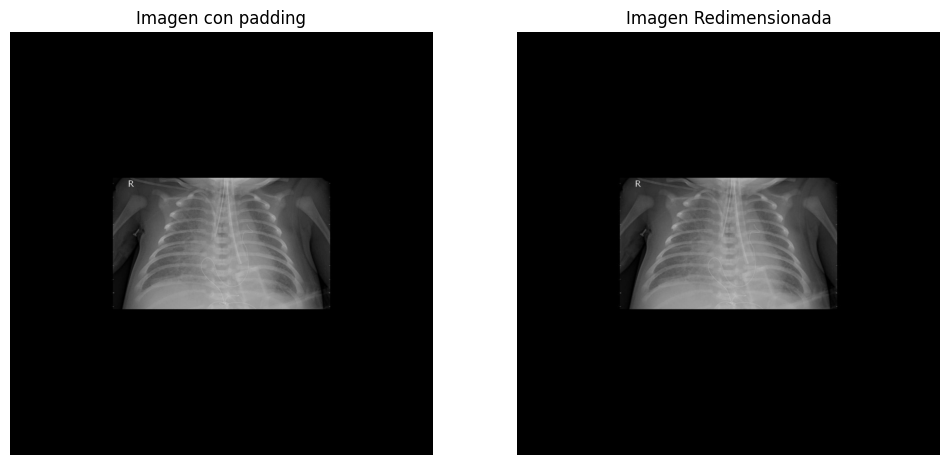

In [ ]:
# Revisamos como quedó una imagen con padding y redimensionada de la carpeta train
image_filename = 'person1260_bacteria_3218.jpeg'

ruta_imagen_padding = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/train/neumonia', image_filename)
ruta_imagen_redimensionada = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/train/neumonia', image_filename)

imagen_original = Image.open(ruta_imagen_padding)
imagen_redimensionada = Image.open(ruta_imagen_redimensionada)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagen_original, cmap='gray')
plt.title('Imagen con padding')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagen_redimensionada, cmap='gray')
plt.title('Imagen Redimensionada')
plt.axis('off')

plt.show()


**Observaciones:** no se aprecia pérdida de calidad en la imagen redimensionada de la carpeta train.

In [ ]:
# Comprobamos que la imagen redimensionada quedó con el tamaño definido
imagen_padding = Image.open(ruta_imagen_padding)
imagen_redimensionada = Image.open(ruta_imagen_redimensionada)

tamano_padding = imagen_padding.size
tamano_redimensionada = imagen_redimensionada.size

print("Tamaño de la imagen con padding:", tamano_padding)
print("Tamaño de la imagen redimensionada:", tamano_redimensionada)

Tamaño de la imagen con padding: (1440, 1440)
Tamaño de la imagen redimensionada: (720, 720)


**Observaciones:** se observa que la imagen redimensionada quedó del tamaño definido (720x720).

In [ ]:
# Redimensiono las imágenes de la carpeta test y obtengo la nueva ruta
input_directory_padding = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/test'
output_directory_redimensionada = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/test'

image_paths_padding = [os.path.join(root, file)
                       for root, _, files in os.walk(input_directory_padding)
                       for file in files if file.endswith(('jpeg', 'jpg', 'png'))]

nueva_ruta_redimensionada = redimensionar_imagenes_con_padding(image_paths_padding, output_directory_redimensionada)

Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/test/neumonia/person108_bacteria_506.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/test/neumonia/person100_bacteria_477.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/test/neumonia/person153_bacteria_725.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/test/neumonia/person86_bacteria_428.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/test/neumonia/person95_bacteria_463.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/test/neumonia/person82_bacteria_404.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/

In [ ]:
# Actualizo el dataframe de test con una nueva columna y lo guardo
df_test_submuestreo_con_ruta['Ruta Redimensionada'] = nueva_ruta_redimensionada

df_test_submuestreo_con_ruta.to_csv('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_test_redimensionado.csv', index=False)


In [ ]:
# Revisamos como quedaron las primeras 5 filas, para seleccionar una imagen para visualizarla
df_test_submuestreo_con_ruta.head()

,Carpeta,Categoría,Sub categoría,Nombre imagen,Ancho,Alto,Modo,Nueva Ruta,Nueva Ruta Procesada,Ruta con Padding,Ruta Redimensionada
0,test,neumonia,bacteria,person108_bacteria_506.jpeg,1184,1032,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
1,test,neumonia,bacteria,person100_bacteria_477.jpeg,1024,680,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
2,test,neumonia,bacteria,person153_bacteria_725.jpeg,1464,808,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
3,test,neumonia,bacteria,person86_bacteria_428.jpeg,832,552,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
4,test,neumonia,bacteria,person95_bacteria_463.jpeg,1000,704,L,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...


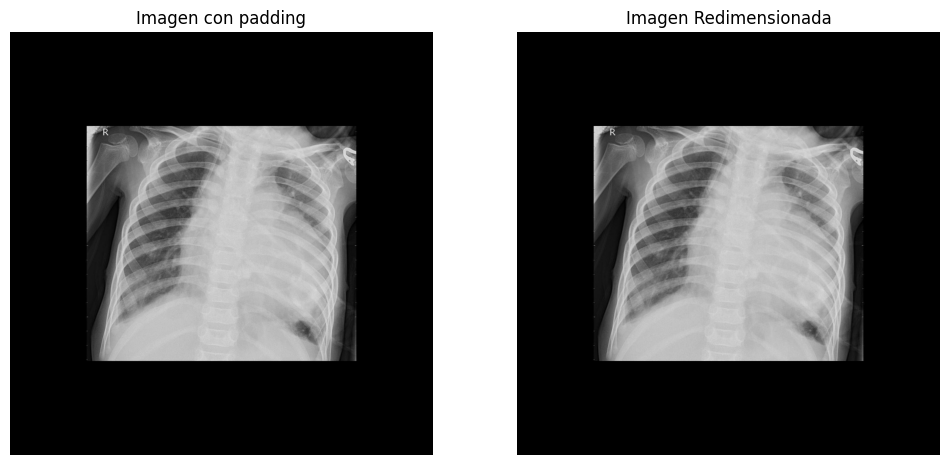

In [ ]:
# Revisamos como quedó una imagen con padding y redimensionada de la carpeta test
image_filename = 'person108_bacteria_506.jpeg'

ruta_imagen_padding = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/test/neumonia', image_filename)
ruta_imagen_redimensionada = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/test/neumonia', image_filename)

imagen_original = Image.open(ruta_imagen_padding)
imagen_redimensionada = Image.open(ruta_imagen_redimensionada)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagen_original, cmap='gray')
plt.title('Imagen con padding')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagen_redimensionada, cmap='gray')
plt.title('Imagen Redimensionada')
plt.axis('off')

plt.show()

**Observaciones:** no se aprecia pérdida de calidad en la imagen redimensionada de la carpeta test.

In [ ]:
# Redimensiono las imágenes de la carpeta val y obtengo la nueva ruta
input_directory_padding = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/val'
output_directory_redimensionada = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/val'

image_paths_padding = [os.path.join(root, file)
                       for root, _, files in os.walk(input_directory_padding)
                       for file in files if file.endswith(('jpeg', 'jpg', 'png'))]

nueva_ruta_redimensionada = redimensionar_imagenes_con_padding(image_paths_padding, output_directory_redimensionada)

Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/val/neumonia/person1950_bacteria_4881.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/val/neumonia/person1951_bacteria_4882.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/val/neumonia/person1954_bacteria_4886.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/val/neumonia/person1946_bacteria_4874.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/val/neumonia/person1952_bacteria_4883.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/val/neumonia/person1946_bacteria_4875.jpeg
Imagen guardada en: /content/drive/MyDrive/Proyecto 

In [ ]:
# Actualizo el dataframe de val con una nueva columna y lo guardo
df_val['Ruta Redimensionada'] = nueva_ruta_redimensionada

df_val.to_csv('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/df_val_redimensionado.csv', index=False)


In [ ]:
# Revisamos las primeras 5 filas del dataframe de val, para seleccionar una imagen para visualizarla
df_val.head()

,Carpeta,Categoría,Sub categoría,Nombre imagen,Ancho,Alto,Modo,Ruta de Imagen,Ruta de Imagen Procesada,Ruta con Padding,Ruta Redimensionada
0,val,neumonia,bacteria,person1950_bacteria_4881.jpeg,1256,864,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
1,val,neumonia,bacteria,person1951_bacteria_4882.jpeg,1016,656,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
2,val,neumonia,bacteria,person1954_bacteria_4886.jpeg,1664,1128,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
3,val,neumonia,bacteria,person1946_bacteria_4874.jpeg,968,592,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...
4,val,neumonia,bacteria,person1952_bacteria_4883.jpeg,1192,952,L,/content/drive/MyDrive/Proyecto modulo 7/data/...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...,/content/drive/MyDrive/Proyecto modulo 7/prueb...


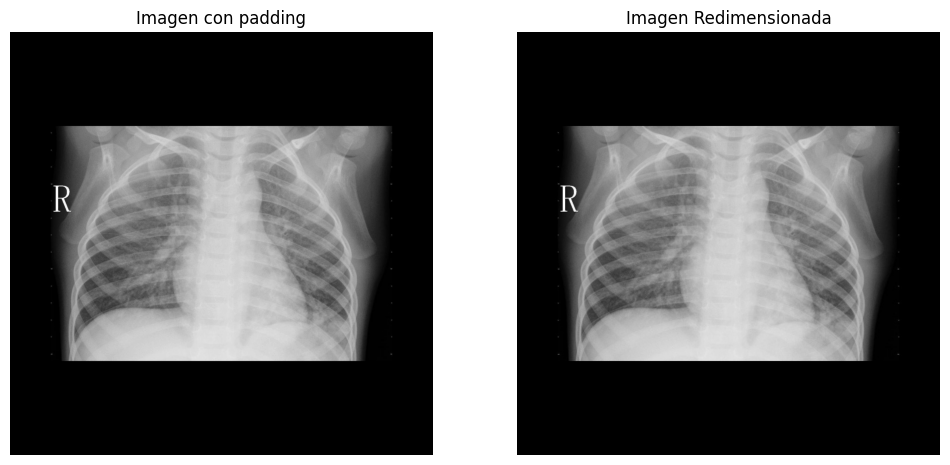

In [ ]:
# Revisamos como quedó una imagen con padding y redimensionada de la carpeta test

image_filename = 'person1950_bacteria_4881.jpeg'

ruta_imagen_padding = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/padded/val/neumonia', image_filename)
ruta_imagen_redimensionada = os.path.join('/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/redimensionada/val/neumonia', image_filename)

imagen_original = Image.open(ruta_imagen_padding)
imagen_redimensionada = Image.open(ruta_imagen_redimensionada)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagen_original, cmap='gray')
plt.title('Imagen con padding')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagen_redimensionada, cmap='gray')
plt.title('Imagen Redimensionada')
plt.axis('off')

plt.show()

**Observaciones:** no se aprecia pérdida de calidad en la imagen redimensionada de la carpeta val.

# **SEPARACIÓN DE CARACTERÍSTICAS**

---
Defino la X e y de cada carpeta


In [ ]:
df_test_submuestreo_con_ruta.columns

Index(['Carpeta', 'Categoría', 'Sub categoría', 'Nombre imagen', 'Ancho',
       'Alto', 'Modo', 'Nueva Ruta', 'Nueva Ruta Procesada',
       'Ruta con Padding', 'Ruta Redimensionada'],
      dtype='object')

In [ ]:
df_train_submuestreo_con_ruta.columns

Index(['Carpeta', 'Categoría', 'Sub categoría', 'Nombre imagen', 'Ancho',
       'Alto', 'Modo', 'Nueva Ruta', 'Nueva Ruta Procesada',
       'Ruta con Padding', 'Ruta Redimensionada'],
      dtype='object')

In [ ]:
df_val.columns

Index(['Carpeta', 'Categoría', 'Sub categoría', 'Nombre imagen', 'Ancho',
       'Alto', 'Modo', 'Ruta de Imagen', 'Ruta de Imagen Procesada',
       'Ruta con Padding', 'Ruta Redimensionada'],
      dtype='object')

In [ ]:
# Separo las caracteristicas

X_train = df_train_submuestreo_con_ruta[['Ruta Redimensionada', 'Nombre imagen']]
X_test = df_test_submuestreo_con_ruta[['Ruta Redimensionada', 'Nombre imagen']]
X_val = df_val[['Ruta Redimensionada', 'Nombre imagen']]

categoria_map = {'normal': 0, 'neumonia': 1}

y_train = df_train_submuestreo_con_ruta['Categoría'].map(categoria_map)
y_test = df_test_submuestreo_con_ruta['Categoría'].map(categoria_map)
y_val = df_val['Categoría'].map(categoria_map)

In [ ]:
# Guardo las características
directorio_guardado = '/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo'

os.makedirs(directorio_guardado, exist_ok=True)

joblib.dump(X_train, os.path.join(directorio_guardado, 'X_train.joblib'))
joblib.dump(y_train, os.path.join(directorio_guardado, 'y_train.joblib'))

joblib.dump(X_test, os.path.join(directorio_guardado, 'X_test.joblib'))
joblib.dump(y_test, os.path.join(directorio_guardado, 'y_test.joblib'))

joblib.dump(X_val, os.path.join(directorio_guardado, 'X_val.joblib'))
joblib.dump(y_val, os.path.join(directorio_guardado, 'y_val.joblib'))

['/content/drive/MyDrive/Proyecto modulo 7/prueba/data_procesada/data_para_modelo/y_val.joblib']